In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math
import matplotlib.patches as patches
import time

import scipy

In [2]:
import importlib  

module = importlib.import_module('0) APIs')
detect_and_refine_boundingBox = module.detect_and_refine_boundingBox

In [3]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

../images/UPC#12.BMP


<IPython.core.display.Javascript object>


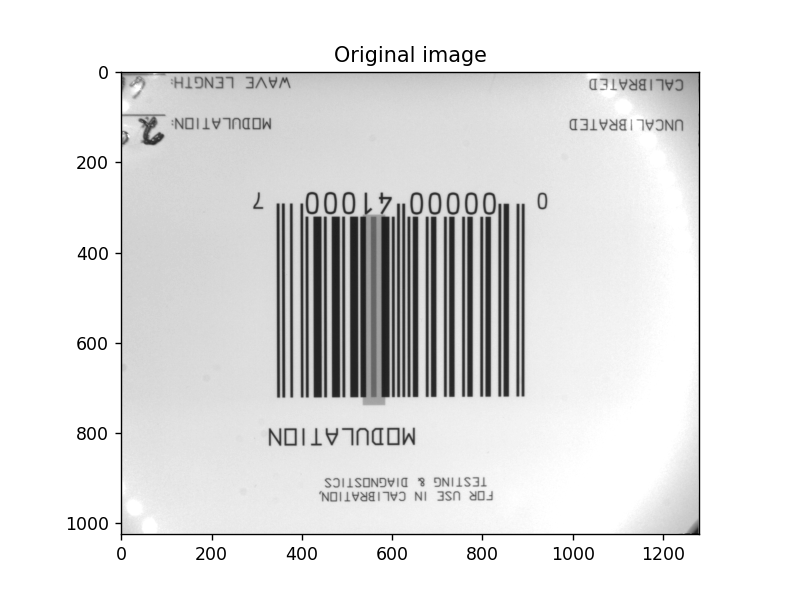

Text(0.5, 1.0, 'Original image')

In [655]:
image_path = f'../images/{images_paths[32]}'
print(image_path)
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   

plt.figure()
plt.imshow(gray, 'gray')
plt.title('Original image')  

<IPython.core.display.Javascript object>


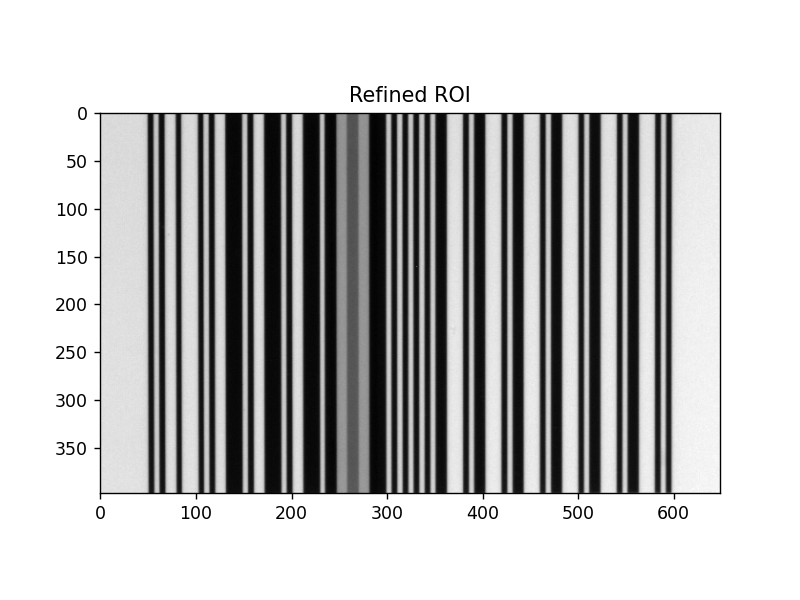

In [656]:
roi_image, bb_points_sorted_rot, bb_width, bb_height = detect_and_refine_boundingBox(image, 
                            use_same_threshold=False, compute_barcode_structure_algorithm=1, verbose_timing=False,
                            outlier_detection_level=0.02, visualization_dict={'visualize_refined_roi':True})

## COMPUTING THE SCAN LINES

In [657]:
bb_height

398

In [658]:
scanlines_indices = np.linspace(start=0, stop=bb_height, num=12, dtype=int)[1:-1]
scanlines_indices

array([ 36,  72, 108, 144, 180, 217, 253, 289, 325, 361])

<IPython.core.display.Javascript object>


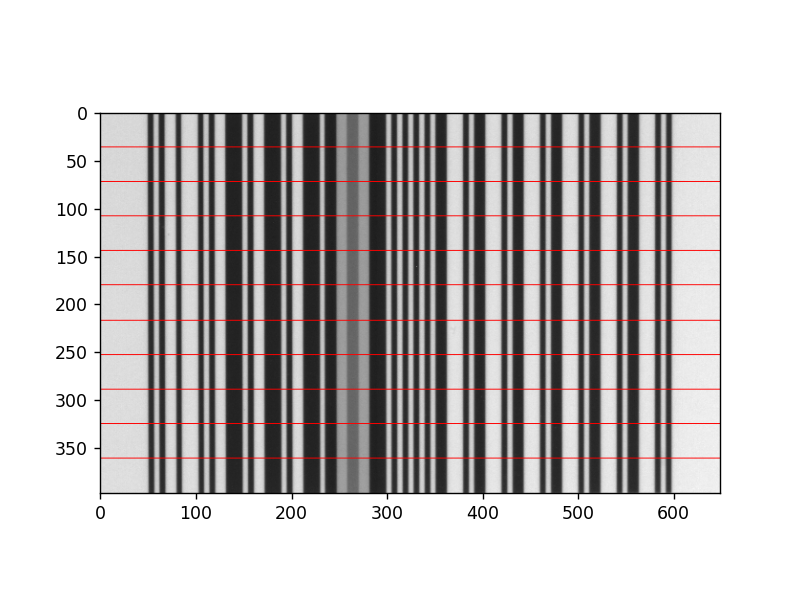

In [659]:
roi_image_tmp = roi_image.copy()
roi_image_tmp = cv2.cvtColor(roi_image_tmp, cv2.COLOR_GRAY2RGB)
roi_image_tmp[scanlines_indices,:,:] = np.array([255,0,0])
plt.figure()
plt.imshow(roi_image_tmp, 'gray') 

## NORMALIZING THE IMAGE

In [660]:
roi_image_norm = 100*(roi_image/255)

In [661]:
roi_image_norm

array([[84.31372549, 83.92156863, 83.52941176, ..., 89.80392157,
        90.19607843, 89.80392157],
       [83.92156863, 83.1372549 , 83.52941176, ..., 90.58823529,
        90.19607843, 89.80392157],
       [84.70588235, 84.31372549, 84.70588235, ..., 88.62745098,
        90.98039216, 89.41176471],
       ...,
       [88.23529412, 88.23529412, 87.84313725, ..., 95.29411765,
        94.50980392, 94.90196078],
       [87.84313725, 86.2745098 , 86.2745098 , ..., 94.90196078,
        94.90196078, 92.94117647],
       [86.66666667, 86.66666667, 86.66666667, ..., 94.90196078,
        94.11764706, 92.54901961]])

In [662]:
#roi_image_norm

In [663]:
#roi_image_norm

In [664]:
#roi_image_norm = np.rint(100*(roi_image/255))

In [665]:
#roi_image_norm

## COMPUTING THE PARAMETERS ON ONE SCANLINE
We focus on one scanline, and we compute the parameters.

<IPython.core.display.Javascript object>


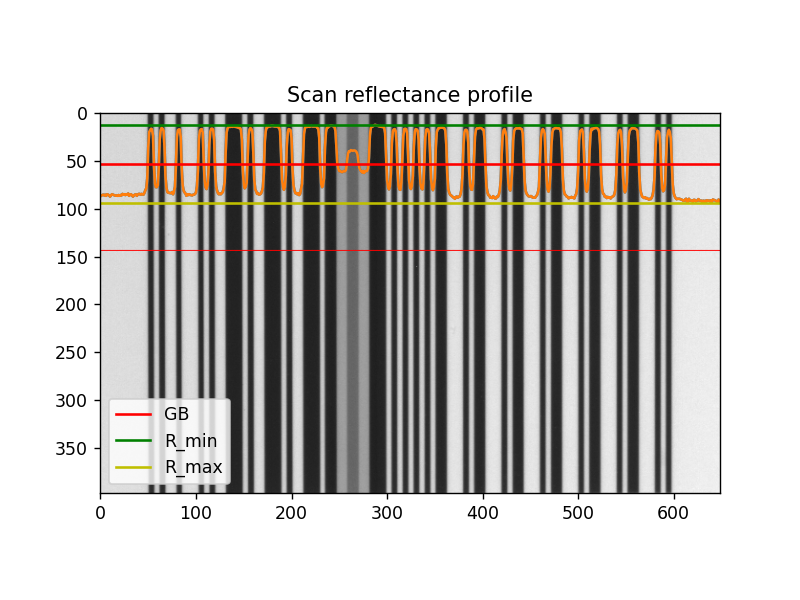

In [666]:
scanline_index = scanlines_indices[3]#math.ceil(bb_height/2)

roi_image_tmp = roi_image.copy()
roi_image_tmp = cv2.cvtColor(roi_image_tmp, cv2.COLOR_GRAY2RGB)
roi_image_tmp[scanline_index,:,:] = np.array([255,0,0])
plt.figure()
plt.imshow(roi_image_tmp, 'gray') 

In [667]:
scanline = roi_image_norm[scanline_index, :]

In [668]:
plt.plot(scanline)
plt.title('Scan reflectance profile')

Text(0.5, 1.0, 'Scan reflectance profile')

### R_min, R_max, SC, GB

In [669]:
100*(roi_image[scanline_index,:].max()-roi_image[scanline_index,:].min())/255

81.17647058823529

In [670]:
math.floor(scanline.max())-math.floor(scanline.min())

81

In [671]:
R_min = scanline.min()
R_max = scanline.max()

In [672]:
R_min, R_max

(12.156862745098039, 93.33333333333333)

In [673]:
SC = R_max - R_min
SC

81.17647058823529

In [674]:
GB = R_min + SC/2
GB

52.745098039215684

In [675]:
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.axhline(R_min, c='g', label='R_min')
plt.axhline(R_max, c='y', label='R_max')
plt.title('Scan reflectance profile')
plt.legend()

The wrong black line within a space can be noticed.

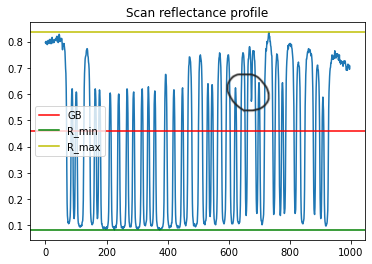

### Edges

In [676]:
mask = (scanline<GB).astype(int)
print(mask)
print()
mask_1 = np.append([0],mask[:-1])
print(mask_1) 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0
 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1
 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 

In [677]:
edges_mask = np.abs(mask - mask_1).astype(bool)
edges_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [678]:
np.indices((mask.shape[0],))

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [679]:
edges_indices = np.indices(mask.shape)[0][edges_mask]
edges_indices

array([ 50,  56,  62,  68,  80,  85, 103, 109, 114, 120, 131, 149, 154,
       161, 172, 190, 195, 201, 212, 230, 235, 248, 258, 271, 281, 300,
       305, 311, 316, 323, 328, 334, 339, 346, 351, 363, 380, 386, 391,
       403, 420, 426, 432, 444, 460, 467, 472, 484, 501, 507, 512, 524,
       541, 547, 552, 564, 581, 587, 592, 599])

In [680]:
n_elements = len(edges_indices)+1

<IPython.core.display.Javascript object>


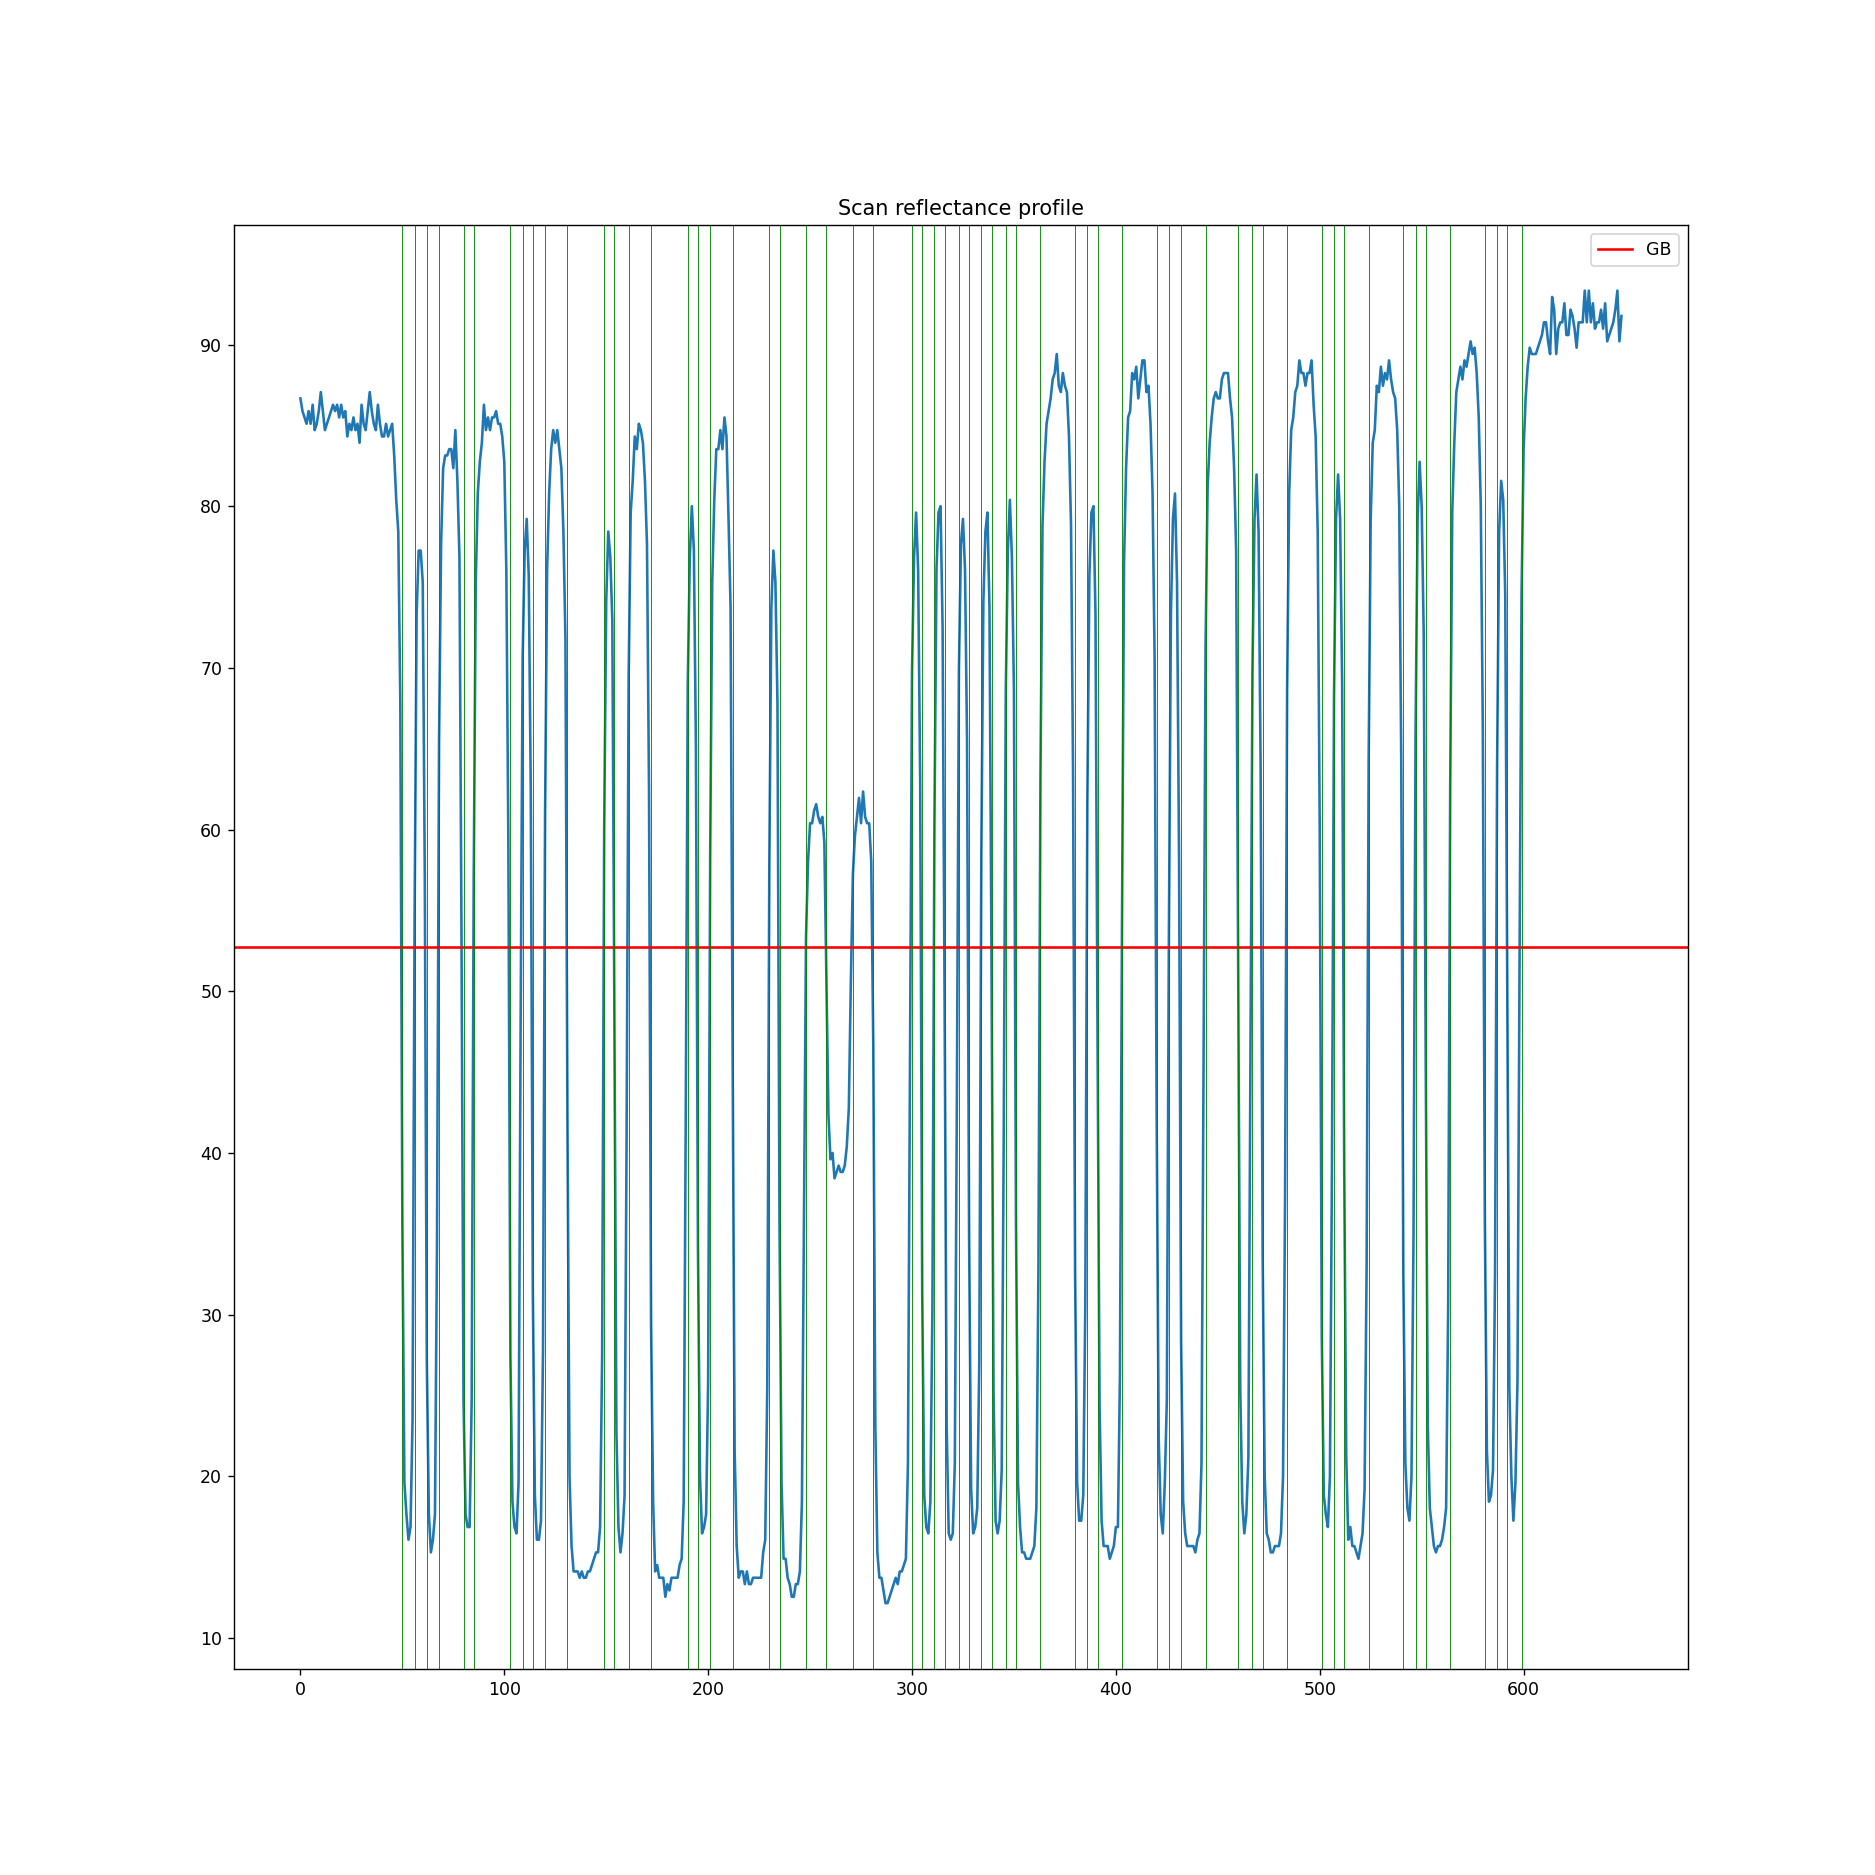

In [690]:
%matplotlib notebook
plt.figure(figsize=(15,15))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
for i in edges_indices:
    plt.axvline(i, c='g', lw=0.5)
plt.title('Scan reflectance profile')
plt.legend()

### Finding the peaks and the valleys

In [682]:
peaks_indices = scipy.signal.find_peaks(scanline)
peaks_indices = peaks_indices[0]
peaks_indices

array([  4,   6,  10,  16,  18,  20,  22,  24,  26,  28,  30,  34,  38,
        42,  45,  58,  73,  76,  90,  92,  96, 111, 124, 126, 138, 151,
       164, 166, 175, 180, 192, 206, 208, 216, 219, 232, 253, 256, 261,
       264, 274, 276, 292, 302, 314, 325, 337, 348, 371, 374, 389, 408,
       410, 413, 416, 429, 449, 454, 469, 490, 496, 509, 515, 528, 530,
       532, 534, 549, 569, 571, 574, 576, 589, 603, 610, 614, 620, 623,
       630, 632, 634, 638, 640, 646], dtype=int64)

<IPython.core.display.Javascript object>


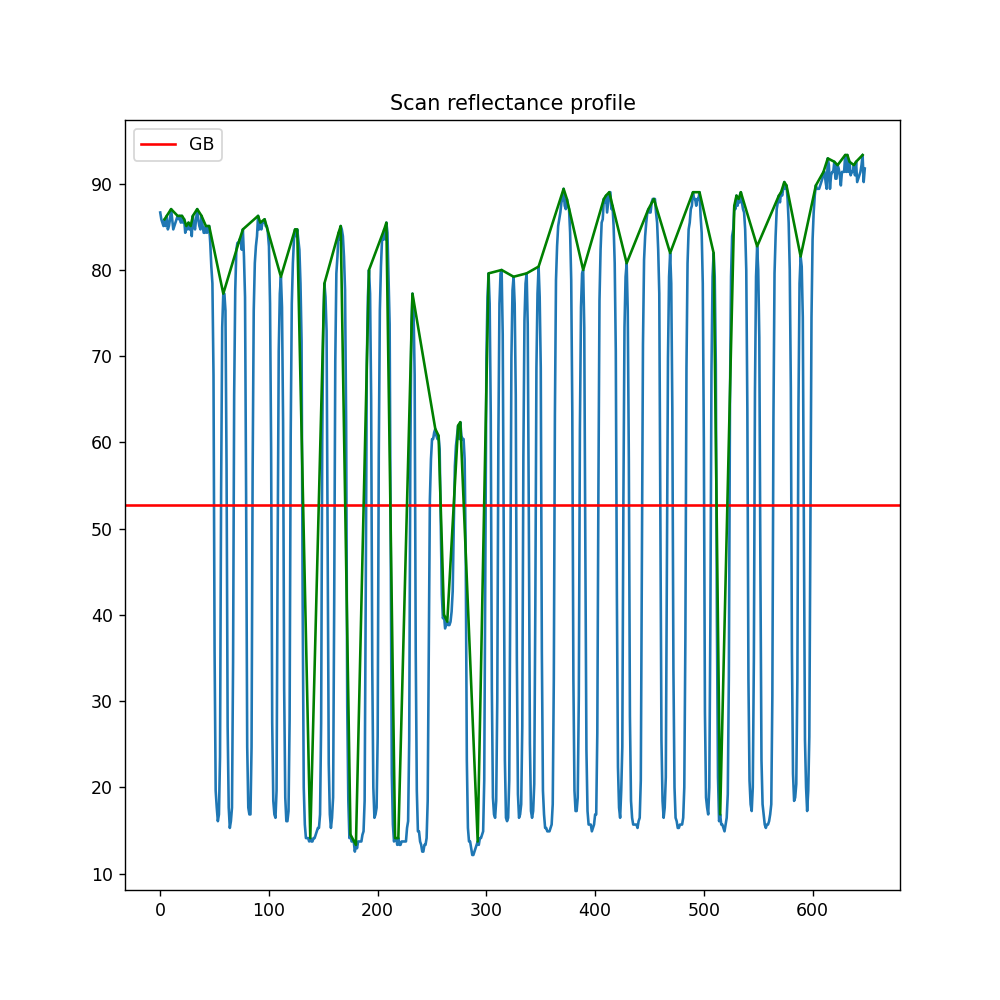

In [691]:
%matplotlib notebook
plt.figure(figsize=(8,8))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot(peaks_indices, scanline[peaks_indices], c='g')
plt.title('Scan reflectance profile')
plt.legend()

In [684]:
valleys_indices = scipy.signal.find_peaks(100-scanline)
valleys_indices = valleys_indices[0]
valleys_indices

array([  3,   5,   7,  12,  17,  19,  21,  23,  25,  27,  29,  32,  37,
        40,  43,  53,  64,  75,  82,  91,  93, 106, 116, 125, 137, 139,
       157, 165, 174, 179, 181, 197, 207, 215, 218, 220, 241, 255, 260,
       262, 265, 275, 287, 293, 308, 319, 330, 342, 357, 373, 382, 397,
       409, 411, 415, 423, 439, 450, 463, 476, 493, 504, 514, 519, 529,
       531, 533, 544, 557, 570, 572, 575, 583, 595, 605, 613, 616, 621,
       626, 631, 633, 635, 639, 641, 647], dtype=int64)

<IPython.core.display.Javascript object>


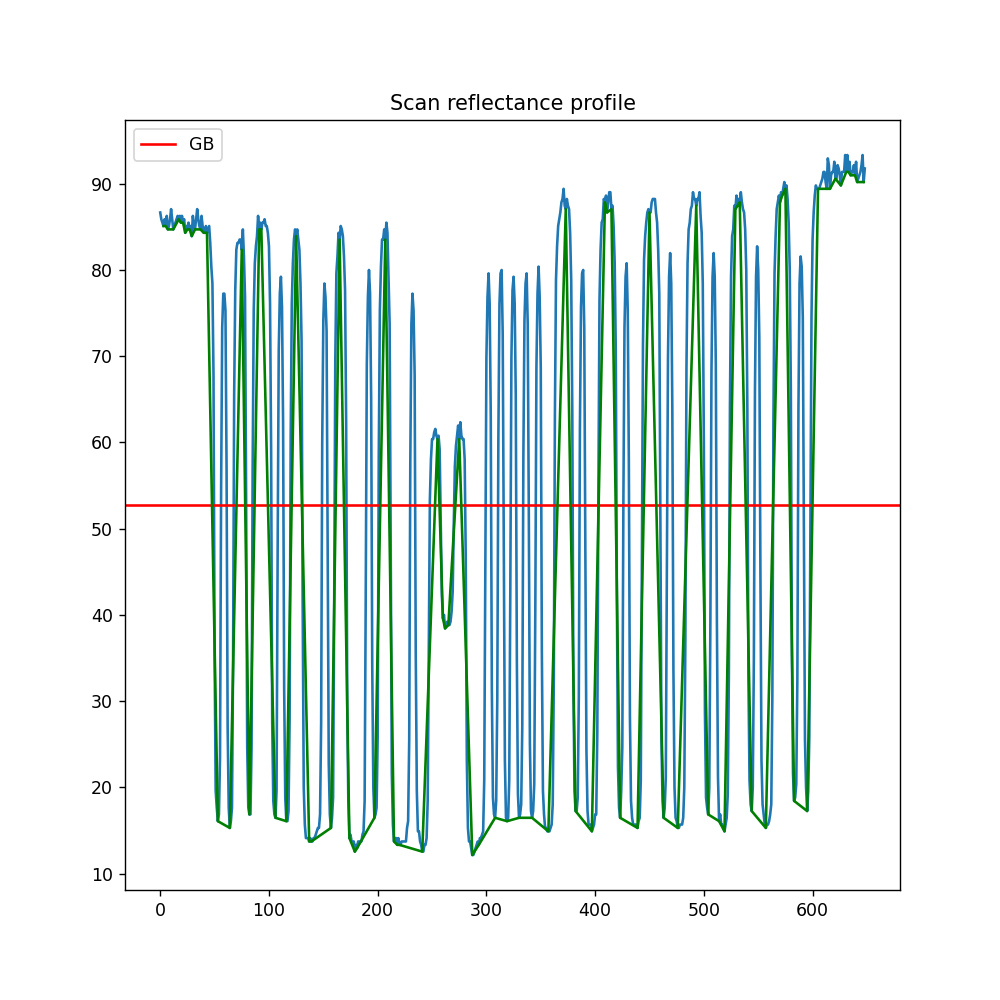

In [692]:
%matplotlib notebook
plt.figure(figsize=(8,8))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot(valleys_indices, scanline[valleys_indices], c='g')
plt.title('Scan reflectance profile')
plt.legend()

### EC_min

In [693]:
EC_list = []
peaksValleys_adjacentElements_list = []

for i in range(n_elements-1):
    print(i)
    if i==0:
        element1_first_index = 0
        element1_last_index = edges_indices[0]-1
        element2_first_index = edges_indices[0]
        element2_last_index = edges_indices[1]-1
    else:
        element1_first_index = edges_indices[i-1]
        element1_last_index = edges_indices[i]-1
        element2_first_index = edges_indices[i]
        if i!=n_elements-2:
            element2_last_index = edges_indices[i+1]-1
        else:
            element2_last_index = scanline.shape[0]-1
    element1_bar = scanline[element1_first_index]<GB
    element2_bar = scanline[element2_first_index]<GB
    print(element1_bar,element2_bar)
    if (element1_bar and element2_bar) or (not element1_bar and not element2_bar):
        raise ValueError('Discordant adjacent elements')
    if element1_bar and not element2_bar:
        barElement_first_index, barElement_last_index = element1_first_index, element1_last_index
        spaceElement_first_index, spaceElement_last_index = element2_first_index, element2_last_index
    else:
        barElement_first_index, barElement_last_index = element2_first_index, element2_last_index
        spaceElement_first_index, spaceElement_last_index = element1_first_index, element1_last_index
    #print(barElement_first_index, barElement_last_index)
    #print(spaceElement_first_index, spaceElement_last_index)
    valleys_indices_within_barElement = valleys_indices[np.logical_and(valleys_indices>=barElement_first_index,valleys_indices<=barElement_last_index)]
    peaks_indices_within_barElement = peaks_indices[np.logical_and(peaks_indices>=barElement_first_index,peaks_indices<=barElement_last_index)]
    indicesOfInterest_within_barElement = valleys_indices_within_barElement#np.concatenate([valleys_indices_within_barElement,peaks_indices_within_barElement])
    if indicesOfInterest_within_barElement.size==0:
            continue
    max_index_barElement = indicesOfInterest_within_barElement[np.argmax(scanline[indicesOfInterest_within_barElement])]
    max_value_barElement = np.max(scanline[indicesOfInterest_within_barElement])
    print(max_value_barElement)
    
    #print(spaceElement_first_index,spaceElement_last_index)
    peaks_indices_within_spaceElement = peaks_indices[np.logical_and(peaks_indices>=spaceElement_first_index,peaks_indices<=spaceElement_last_index)]
    valleys_indices_within_spaceElement = valleys_indices[np.logical_and(valleys_indices>=spaceElement_first_index,valleys_indices<=spaceElement_last_index)]
    indicesOfInterest_within_spaceElement = peaks_indices_within_spaceElement#np.concatenate([valleys_indices_within_spaceElement,peaks_indices_within_spaceElement])
    if indicesOfInterest_within_spaceElement.size==0:
            continue
    min_index_spaceElement = indicesOfInterest_within_spaceElement[np.argmin(scanline[indicesOfInterest_within_spaceElement])]
    min_value_spaceElement = np.min(scanline[indicesOfInterest_within_spaceElement])
    print(min_value_spaceElement)
    
    print(min_value_spaceElement-max_value_barElement)
    
    EC_list.append(min_value_spaceElement-max_value_barElement)
    print((min_index_spaceElement,max_index_barElement))
    peaksValleys_adjacentElements_list.append((min_index_spaceElement,max_index_barElement))
    
EC_min = min(EC_list)
EC_min

0
False True
16.07843137254902
85.09803921568627
69.01960784313725
(24, 53)
1
True False
16.07843137254902
77.25490196078432
61.176470588235304
(58, 53)
2
False True
15.294117647058824
77.25490196078432
61.9607843137255
(58, 64)
3
True False
15.294117647058824
83.52941176470588
68.23529411764706
(73, 64)
4
False True
16.862745098039216
83.52941176470588
66.66666666666667
(73, 82)
5
True False
16.862745098039216
85.49019607843137
68.62745098039215
(92, 82)
6
False True
16.470588235294116
85.49019607843137
69.01960784313725
(92, 106)
7
True False
16.470588235294116
79.2156862745098
62.74509803921569
(111, 106)
8
False True
16.07843137254902
79.2156862745098
63.13725490196079
(111, 116)
9
True False
16.07843137254902
84.70588235294117
68.62745098039215
(124, 116)
10
False True
13.725490196078432
84.70588235294117
70.98039215686273
(124, 137)
11
True False
13.725490196078432
78.43137254901961
64.70588235294119
(151, 137)
12
False True
15.294117647058824
78.43137254901961
63.13725490196079


21.17647058823529

In [694]:
np.argmin(EC_list)

22

In [695]:
MODULATION = EC_min / SC
MODULATION

0.26086956521739124

256 260


<IPython.core.display.Javascript object>


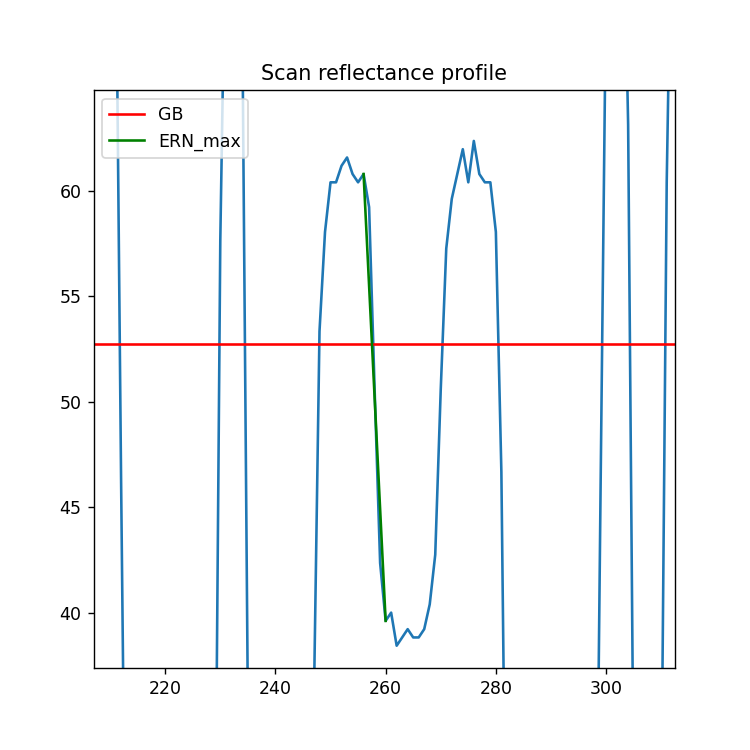

In [696]:
# Visualize ERN_max
min_index_spaceElement,max_index_barElement = peaksValleys_adjacentElements_list[np.argmin(EC_list)]
print(min_index_spaceElement,max_index_barElement)
min_value_spaceElement,max_value_barElement = scanline[min_index_spaceElement], scanline[max_index_barElement]

%matplotlib notebook
plt.figure(figsize=(6,6))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot([min_index_spaceElement,max_index_barElement], [min_value_spaceElement,max_value_barElement], c='g', label='ERN_max')
plt.title('Scan reflectance profile')
plt.legend()

### Defects

In [509]:
n_elements

71

In [510]:
scanline.shape

(997,)

In [519]:
ERN_list = []
peaks_valleys_elements_list = []

for i in range(n_elements):
    if i==0:
        element_first_index = 0
        element_last_index = edges_indices[0]-1
    elif i<n_elements-1:
        element_first_index = edges_indices[i-1]
        element_last_index = edges_indices[i]-1
    else:
        element_first_index = edges_indices[n_elements-2]
        element_last_index = scanline.shape[0]-1
    peaks_indices_within_element = peaks_indices[np.logical_and(peaks_indices>=element_first_index,peaks_indices<=element_last_index)]
    valleys_indices_within_element = valleys_indices[np.logical_and(valleys_indices>=element_first_index,valleys_indices<=element_last_index)]
    if peaks_indices_within_element.size==0 or valleys_indices_within_element.size==0:
        ERN_list.append(0)
        peaks_valleys_elements_list.append((None,None))
        continue
    peaks_within_element = scanline[peaks_indices_within_element]#roi_image[scanline_index, peaks_indices_within_element]#scanline[peaks_indices_within_element]
    #print(valleys_within_element)
    valleys_within_element = scanline[valleys_indices_within_element]#roi_image[scanline_index, valleys_indices_within_element]#
    print(peaks_within_element.max(),valleys_within_element.min())
    ERN_list.append(peaks_within_element.max()-valleys_within_element.min())
    #print(np.argmin(valleys_within_element))
    #print(valleys_indices_within_element.shape)
    peaks_valleys_elements_list.append((peaks_indices_within_element[np.argmax(peaks_within_element)],valleys_indices_within_element[np.argmin(valleys_within_element)]))
    
ERN_max = max(ERN_list)
ERN_max

DEFECTS = ERN_max / SC

DEFECTS     

81.56862745098039 78.82352941176471
10.980392156862745 10.588235294117647
10.588235294117647 9.411764705882353
76.07843137254902 75.29411764705883
10.980392156862745 10.588235294117647
9.411764705882353 9.019607843137255
9.803921568627452 8.627450980392156
10.588235294117647 10.196078431372548
9.411764705882353 8.627450980392156
10.588235294117647 10.196078431372548
9.411764705882353 8.235294117647058
9.803921568627452 9.411764705882353
9.411764705882353 9.019607843137255
10.196078431372548 9.019607843137255
75.29411764705883 74.50980392156863
10.980392156862745 10.588235294117647
77.64705882352942 58.43137254901961
82.35294117647058 77.64705882352942
79.6078431372549 77.64705882352942
76.07843137254902 74.90196078431373
74.11764705882354 70.19607843137254


0.2592592592592593

In [520]:
round(DEFECTS, 1)

0.3

<IPython.core.display.Javascript object>


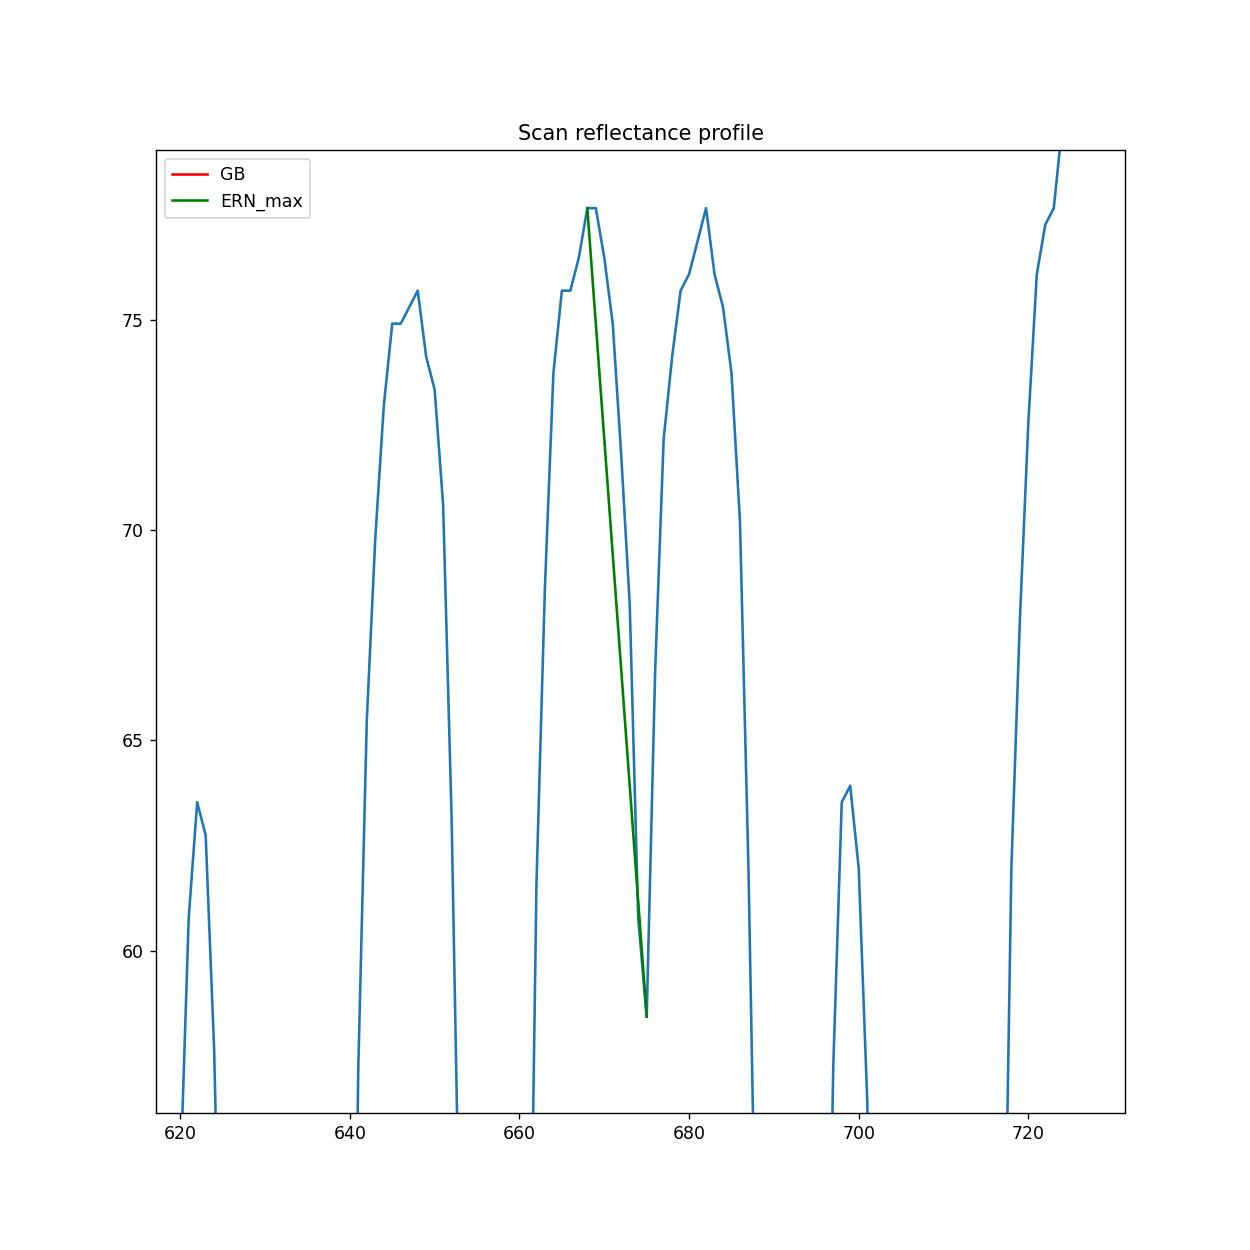

In [521]:
# Visualize ERN_max
peak_index, valley_index = peaks_valleys_elements_list[np.argmax(ERN_list)]
peak_value, valley_value = scanline[peak_index], scanline[valley_index]

%matplotlib notebook
plt.figure(figsize=(10,10))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot([peak_index, valley_index], [peak_value, valley_value], c='g', label='ERN_max')
plt.title('Scan reflectance profile')
plt.legend()

### Testing defects in different scanlines

In [457]:
def compute_defect(scanline):
    R_min = scanline.min()
    R_max = scanline.max()
    SC = R_max - R_min
    GB = R_min + SC/2

    mask = (scanline<GB).astype(int)
    mask_1 = np.append([0],mask[:-1])
    edges_mask = np.abs(mask - mask_1).astype(bool)
    edges_indices = np.indices(mask.shape)[0][edges_mask]
    n_elements = len(edges_indices)+1

    peaks_indices = scipy.signal.find_peaks(scanline)[0]
    valleys_indices = scipy.signal.find_peaks(100-scanline)[0]

    ERN_list = []
    peaks_valleys_elements_list = []
    for i in range(n_elements):
        if i==0:
            element_first_index = 0
            element_last_index = edges_indices[0]
        elif i<n_elements-1:
            element_first_index = edges_indices[i-1]
            element_last_index = edges_indices[i]
        else:
            element_first_index = edges_indices[n_elements-2]
            element_last_index = scanline.shape[0]-1
        peaks_indices_within_element = peaks_indices[np.logical_and(peaks_indices>=element_first_index,peaks_indices<=element_last_index)]
        valleys_indices_within_element = valleys_indices[np.logical_and(valleys_indices>=element_first_index,valleys_indices<=element_last_index)]
        if peaks_indices_within_element.size==0 or valleys_indices_within_element.size==0:
            ERN_list.append(0)
            peaks_valleys_elements_list.append((None,None))
            continue
        peaks_within_element = scanline[peaks_indices_within_element]
        valleys_within_element = scanline[valleys_indices_within_element]
        ERN_list.append(peaks_within_element.max()-valleys_within_element.min())
        peaks_valleys_elements_list.append((peaks_indices_within_element[np.argmax(peaks_within_element)],valleys_indices_within_element[np.argmin(valleys_within_element)]))
    ERN_max = max(ERN_list)
    DEFECTS = ERN_max / SC
    
    return round(DEFECTS, 1)

In [458]:
DEFECTS_list = []
for scanline_index in scanlines_indices:
    scanline = roi_image_norm[scanline_index, :]
    DEFECTS = compute_defect(scanline)
    DEFECTS_list.append(DEFECTS)

In [459]:
DEFECTS_list

[0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [460]:
np.mean(DEFECTS_list)

0.11000000000000001

In [103]:
ERN_list = []
element = scanline[:edges_first_indices[0]]
ERN_list.append(element.max()-element.min())
for i, edge_first_index in enumerate(edges_first_indices): 
    if i>=len(edges_first_indices)-1:
        element = scanline[edge_first_index:]
    else:
        element = scanline[edge_first_index:edges_first_indices[i+1]]
    ERN_list.append(element.max()-element.min())
    
ERN_max = max(ERN_list)

DEFECTS = ERN_max / SC

DEFECTS

0.4868421052631579

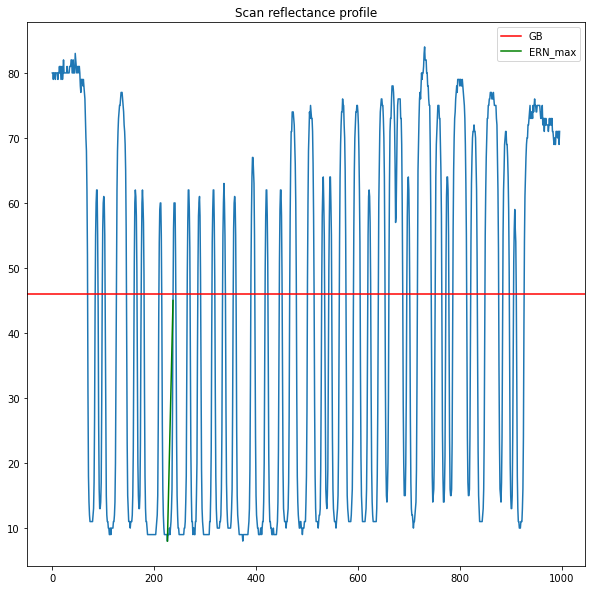

In [104]:
# Visualize ERN_max
ERN_max_edge_index = np.argmax(ERN_list)
if ERN_max_edge_index==0:
    element = scanline[:edges_first_indices[0]]
    element_first_index = 0
elif ERN_max_edge_index<len(ERN_list)-1:
    element = scanline[edges_first_indices[ERN_max_edge_index-1]:edges_first_indices[ERN_max_edge_index]]
    element_first_index = edges_first_indices[ERN_max_edge_index-1]
else:
    element = scanline[edges_first_indices[ERN_max_edge_index-1]:]
    element_first_index = edges_first_indices[ERN_max_edge_index-1]
    
max_index = np.argmax(element) + element_first_index
max_value = np.max(element)
min_index = np.argmin(element) + element_first_index
min_value = np.min(element)

%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot([min_index, max_index], [min_value, max_value], c='g', label='ERN_max')
plt.title('Scan reflectance profile')
plt.legend()

In [105]:
scanline[max_index]

45.0

In [106]:
GB

46.0

In [108]:
roi_image[scanline_index, max_index]

116